In [1]:
using LinearAlgebra
using Random
using Statistics

In [2]:
using QuadGK
using Roots
using QuantumOptics
using PyPlot

## Discrete-time evolution of a DOPO

We iterate the following procedure, once for each roundtrip around the cavity:

1. Evolve $\lvert\psi\rangle \otimes \lvert \beta\rangle$ for time $\tau$ under the crystal Hamiltonian

$$
\hat H_\text{nl} = \frac{\mathrm{i}\epsilon}{2} \hat b \hat a^{\dagger2} + \text{H.c.}
$$

2. Perform measurement of pump mode and conditionally project signal mode.

3. Instantiate the state $\lvert\psi\rangle \otimes \lvert 0\rangle$ and apply the outcoupling beamsplitter unitary

$$
\hat U_\text{out} = \exp\left\lbrack(\arcsin r) \hat a^\dagger \hat b - \text{H.c.}\right\rbrack.
$$

4. Perform measurement of output mode and conditionally project signal mode.

### Interpretation of parameters
In the high-finesse limit where this process takes a roundtrip time $\Delta t \rightarrow 0$, the $q$-quadrature has mean-field equation of motion

$$
\frac{\mathrm{d}\langle\hat q\rangle}{\mathrm{d}t} = (p - \kappa) \langle\hat q\rangle - \frac{g}{2}\langle\hat q\rangle^3,
$$
where
$$
p\Delta t = \beta\epsilon\tau
\qquad
\kappa\Delta t = \frac12r^2
\qquad
g\Delta t = \left(\frac{\epsilon\tau}{2}\right)^2.
$$

For reference, some key figures of merit are
$$
\frac{g}{\kappa} = \frac{(\epsilon\tau)^2}{2r^2}
\qquad\qquad
\frac{p}{\kappa} = \frac{2\beta\epsilon\tau}{r^2}
$$

## Measurement "unravellings"

### Photon-counting measurement

After either steps 1 or 3 above, the system is in a joint state that can be written as

$$
\lvert\Psi\rangle = \sum_n \sum_k c_{n,k} \lvert n \rangle \lvert k \rangle.
$$

The probability of detecting $k$ photons is $p(k) = \sum_n |c_{n,k}|^2$. To sample from this distribution, we generate a random number $z \sim U[0,1]$ and find the largest $k^*$ such that $P(k^*) \leq z$, where $P(k) = \sum_{k'=0}^k p(k')$ is the cumulative distribution function. This corresponds to the measurement operator $\hat M_{k*} = 1 \otimes \lvert k^* \rangle\langle k^* \rvert$.

After measurement the mode $b$ is now separable with mode $a$ so we can project mode $b$ back to vacuum. This post-measurement state is
$$
\lvert\Psi\rangle \mapsto p(k^*)^{-1/2} \sum_n c_{n,k^*} \lvert n\rangle \lvert 0\rangle.
$$

### Homodyne measurement

After either steps 1 or 3 above, the system is in a joint state that can be written as

$$
\lvert\Psi\rangle = \sum_n \sum_k c_{n,k} \lvert n \rangle \lvert k \rangle = \sum_n \int \mathrm{d}q\, c_n(q) \lvert n \rangle \lvert q \rangle,
$$

where $\lvert q \rangle$ is a position eigenstate of mode $b$, and

$$
c_n(q) = \sum_k c_{n,k} \langle q \vert k \rangle.
$$

Note that $\langle q \vert k \rangle$ is simply the position-basis wavefunction of the $k$th energy eigenstate of the quantum harmonic oscillator.

The probability density function for obtaining a homodyne result $q$ is $p(q) = \sum_n |c_n(q)|^2$. To sample from this distribution, we generate a random number $z \sim U[0,1]$ and find the value $q^*$ such that $P(q^*) = z$, where $P(q) = \int_{-\infty}^q p(q') \, \mathrm{d}q'$ is the cumulative distribution function.

After measurement the mode $b$ is now separable with mode $a$ so we can project mode $b$ back to vacuum. This post-measurement state is
$$
\lvert\Psi\rangle \mapsto p(q^*)^{-1/2} \sum_n c_n(q^*) \lvert n\rangle \otimes \lvert 0 \rangle.
$$

## Setup

In [54]:
ϵτ = 1.0
β = 2.0
θ = (asin∘sqrt)(0.01);

In [87]:
basis_a = FockBasis(50)
basis_b = FockBasis(50)
id_a = identityoperator(basis_a)
id_b = identityoperator(basis_b)
a = destroy(basis_a) ⊗ id_b
b = id_a ⊗ destroy(basis_b)
n_b = [id_a ⊗ projector(fockstate(basis_b,i)) for i in 0:basis_b.N];

In [88]:
Hoc = 1im * θ * (a*dagger(b) - dagger(a)*b)
Hxtal = 1im * ϵτ * (b + id_a ⊗ (β/sqrt(2)*id_b)) * dagger(a^2)
Hxtal = 0.5*(Hxtal + dagger(Hxtal));

## Photon-counting

In [105]:
photoncount_b! = let n_b=n_b
    function(ψ::Ket, ψcache::Ket, rng::AbstractRNG=Random.GLOBAL_RNG)
        Fnb = cumsum(real(expect(n,ψ)) for n in n_b)
        Fnb[end] = 1.0
        nb_samp = searchsortedlast(Fnb, rand(rng))
        ψcache .= ψ
        mul!(ψ, n_b[nb_samp+1], ψcache)
        for n in 1:nb_samp
            ψcache .= ψ
            mul!(ψ, b, ψcache)
        end
        normalize!(ψ)
        return nb_samp
    end
end

#91 (generic function with 2 methods)

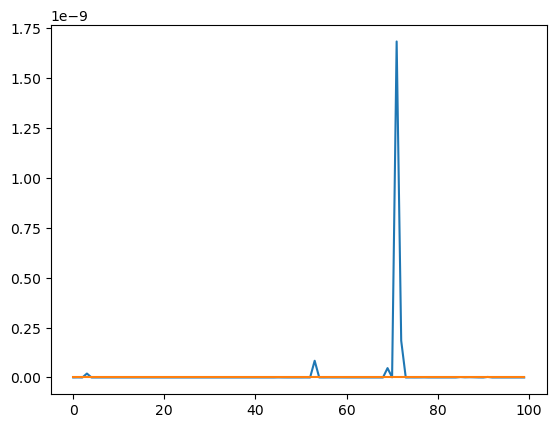

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb9abb32640>

In [111]:
T = 100
x = LinRange(-5, 5, 100)

pump_clicks = zeros(Int, T)
out_clicks = zeros(Int, T)
W = []
truncations_a = zeros(T)
truncations_b = zeros(T)

rng = MersenneTwister(0)
ψ1 = fockstate(basis_a,0) ⊗ fockstate(basis_b,0)
ψ2 = deepcopy(ψ)

for t in 1 : T
    _, (_,ψ2) = timeevolution.schroedinger([0,1], ψ1, Hxtal)
    pump_clicks[t] = photoncount_b!(ψ2, ψ1, rng)
    _, (_,ψ1) = timeevolution.schroedinger([0,1], ψ2, Hoc)
    out_clicks[t] = photoncount_b!(ψ1, ψ2, rng)
    ρ = ptrace(ψ1,2)
    push!(W, wigner(ρ, x, x))
    truncations_a[t] = ρ.data[end,end]
    ρ = ptrace(ψ1,1)
    truncations_b[t] = ρ.data[end,end]
end
plt.plot(truncations_a)
plt.plot(truncations_b)

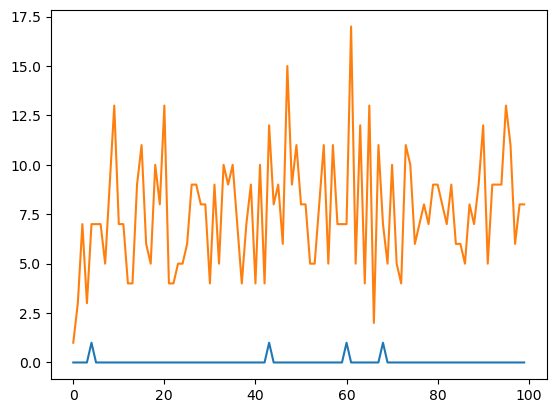

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb9aba8d700>

In [112]:
plot(out_clicks)
plot(pump_clicks)

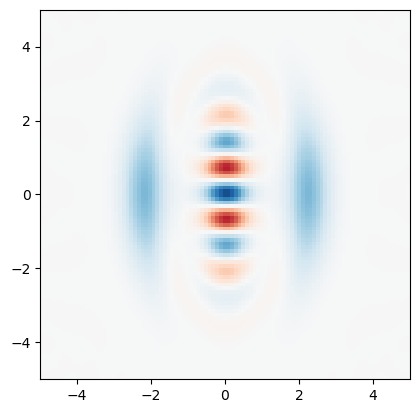

(-5.0, 5.0, -5.0, 5.0)

In [113]:
plt.pcolormesh(x, x, transpose(W_a[50]), vmin=-0.35, vmax=0.35, cmap=:RdBu)
plt.axis(:square)

## Homodyne

In [96]:
include("homodyne.jl")

homodyne_b! (generic function with 2 methods)

In [97]:
hom = Homodyne(basis_a, basis_b);

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


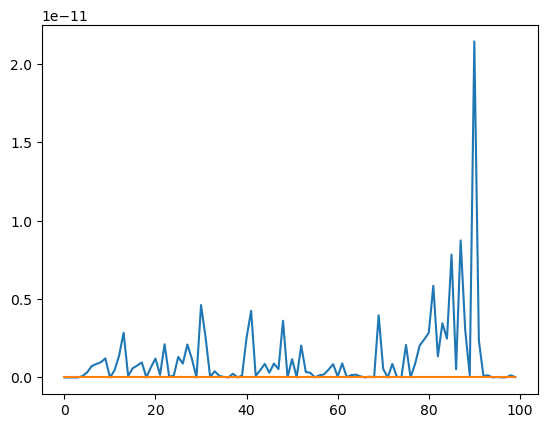

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb9b007f9d0>

In [98]:
T = 100
x = LinRange(-7, 7, 200)


pump_hom = zeros(T)
out_hom = zeros(T)
W = []
truncations_a = zeros(T)
truncations_b = zeros(T)

rng = MersenneTwister(0)
ψ = fockstate(basis_a,0) ⊗ fockstate(basis_b,0)

βt = LinRange(0, β, T)
for t in 1:T
    Hxtal = 1im * ϵτ * (b + id_a ⊗ (βt[t]/sqrt(2)*id_b)) * dagger(a^2)
    Hxtal = 0.5*(Hxtal + dagger(Hxtal))
    t % 10 == 0 && println("$t / $T")
    _, (_,ψ) = timeevolution.schroedinger([0,1], ψ, Hxtal)
    pump_hom[t] = homodyne_b!(hom, ψ, rng)
    _, (_,ψ) = timeevolution.schroedinger([0,1], ψ, Hoc)
    out_hom[t] = homodyne_b!(hom, ψ, rng)
    ρ = ptrace(ψ,2)
    push!(W, wigner(ρ, x, x))
    truncations_a[t] = ρ.data[end,end]
    ρ = ptrace(ψ,1)
    truncations_b[t] = ρ.data[end,end]
end
plt.plot(truncations_a)
plt.plot(truncations_b)

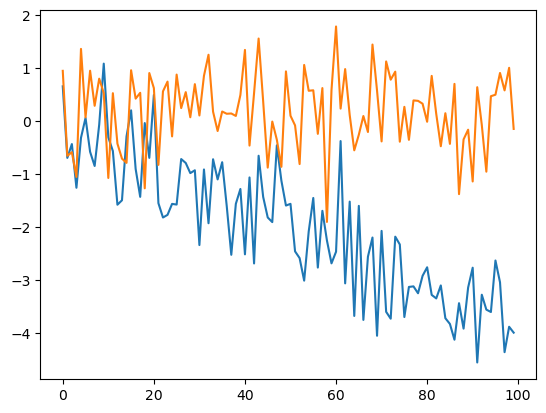

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb9b02ffc10>

In [102]:
plt.plot(pump_hom)
plt.plot(out_hom)

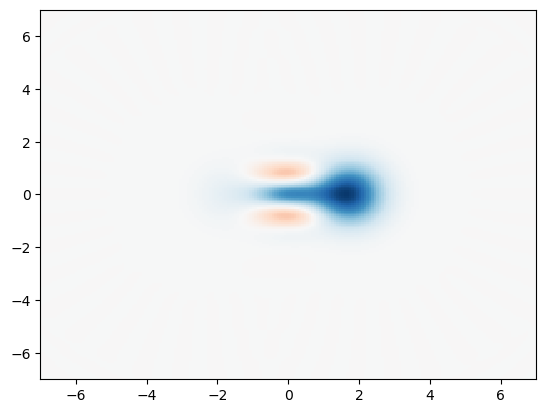

PyObject <matplotlib.collections.QuadMesh object at 0x7fb9b004f640>

In [99]:
plt.pcolormesh(x, x, transpose(W[30]), vmin=-0.3, vmax=0.3, cmap=:RdBu)

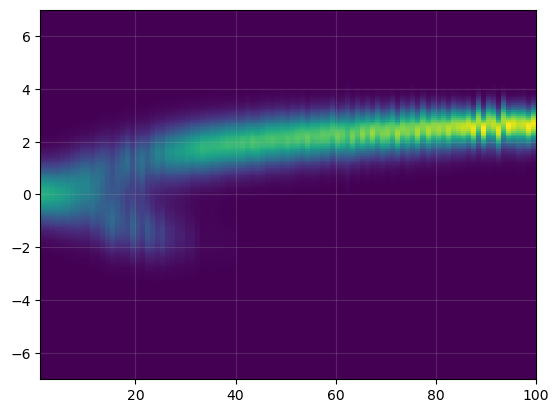

In [103]:
pcolormesh(1:T, x, hcat([sum(W[t],dims=2) for t in 1:T]...))
grid(alpha=0.2)

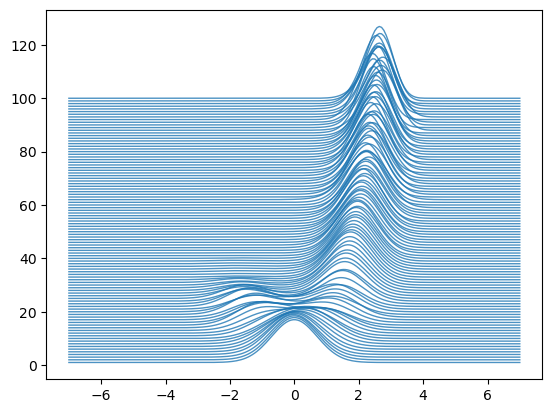

In [104]:
for t in 1:T
    plot(x, 2*sum(W[t],dims=2) .+ 1*t, alpha=0.8, linewidth=1, color="tab:blue")
end